In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from helper_funcs import get_data_loaders, get_model, train_model, evaluate
from Transformers import ProjectionHead
plt.style.use('default')
import torch.optim as optim
import json
from sklearn.model_selection import StratifiedShuffleSplit
from Transformers import MedicalTimeSeriesDatasetTuple, collate_fn, MedicalTimeSeriesDatasetTimeGrid
from torch.utils.data import WeightedRandomSampler, DataLoader
import yaml
import json
import time


In [2]:

# --- Add this near the top of your script ---
def set_seed(seed_value=42):
    """Sets the seed for reproducibility in PyTorch, NumPy, and Python."""
    random.seed(seed_value)  # Python random module
    np.random.seed(seed_value) # Numpy module
    torch.manual_seed(seed_value) # PyTorch CPU seeding

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # if you are using multi-GPU.
        # Configure CuDNN for deterministic operations
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        # Optional: Newer PyTorch versions might require this for full determinism
        # Note: This can sometimes throw errors if a deterministic implementation isn't available
        # try:
        #     torch.use_deterministic_algorithms(True)
        # except Exception as e:
        #     print(f"Warning: Could not enable deterministic algorithms: {e}")
        # Optional: Sometimes needed for deterministic matrix multiplication
        # os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

    print(f"Seed set globally to {seed_value}")



In [3]:
# Load the configuration file with all hyperparameters, model parameters, data paths, etc.
# for tuple: config_tupe_default.yaml
# for time_grid: config_time_grid_default.yaml

with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

config['device'] ="cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
device = config["device"]

seed = config["seed"]
set_seed(seed_value=seed)

# check if the output directory exists, if not create it
if not os.path.exists(config["output_dir"]):
    os.makedirs(config["output_dir"])
    print(f"Output directory {config['output_dir']} created.")
    
date = time.strftime("%Y-%m-%d")

# SET MODEL NAME
model_name = f"{config['model_type']}_model_{config['epochs']}_{date}"
config['model_name'] = model_name


print("Model type selected: ", config["model_type"])
print("Model name: ", model_name)

Seed set globally to 42
Model type selected:  contrast_grid
Model name:  contrast_grid_model_50_2025-04-07


In [4]:
# Was used for tuple dataset
# def info_nce_loss(embeddings1, embeddings2, temperature = 0.2):
#     """
#     embeddings1: Tensor of shape (batch_size, proj_dim) for view 1
#     embeddings2: Tensor of shape (batch_size, proj_dim) for view 2
#     """
#     batch_size = embeddings1.shape[0]

#     # Normalize the embeddings
#     embeddings1 = nn.functional.normalize(embeddings1, dim=1)
#     embeddings2 = nn.functional.normalize(embeddings2, dim=1)

#     similarity_matrix = torch.matmul(embeddings1, embeddings2.T) / temperature # shape (batch_size, batch_size)
#     labels = torch.arange(batch_size, device=embeddings1.device)

#     loss1 = nn.functional.cross_entropy(similarity_matrix, labels)
#     loss2 = nn.functional.cross_entropy(similarity_matrix.T, labels)
#     loss = (loss1 + loss2) / 2.0

#     return loss


class InfoNCELoss(nn.Module):
    def __init__(self, temperature=0.1):
        super().__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, z1, z2):
        """
        Calculates the InfoNCE loss.
        Args:
            z1 (torch.Tensor): Representations of view 1, shape (batch_size, proj_dim).
            z2 (torch.Tensor): Representations of view 2, shape (batch_size, proj_dim).
        Returns:
            torch.Tensor: The InfoNCE loss value.
        """
        batch_size = z1.shape[0]
        device = z1.device

        # Normalize representations
        z1 = F.normalize(z1, p=2, dim=1)
        z2 = F.normalize(z2, p=2, dim=1)

        # Concatenate representations for efficient similarity calculation
        representations = torch.cat([z1, z2], dim=0) # Shape: (2 * batch_size, proj_dim)

        # Calculate cosine similarity matrix
        # sim_matrix[i, j] = similarity between representations[i] and representations[j]
        sim_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
        # Shape: (2 * batch_size, 2 * batch_size)

        # Mask out diagonal similarities (similarity of a sample with itself)
        # Create a mask where diagonal elements are False, others are True
        mask = torch.eye(2 * batch_size, dtype=torch.bool, device=device)
        sim_matrix = sim_matrix.masked_fill(mask, float('-inf')) # Set diagonal to -inf before exp

        # Apply temperature scaling
        sim_matrix = sim_matrix / self.temperature

        # Labels: identify positive pairs
        # The positive pair for z1[i] is z2[i] (at index batch_size + i)
        # The positive pair for z2[i] is z1[i] (at index i)
        labels = torch.arange(batch_size, device=device) # Labels for the first half (z1) point to the second half (z2)
        labels = torch.cat([labels + batch_size, labels]) # Correct labels for both halves

        # Calculate CrossEntropyLoss
        # The logits for sample i are the similarities between representations[i] and all other representations.
        # The target label points to the index of the positive pair for sample i.
        loss = self.criterion(sim_matrix, labels)

        return loss

In [5]:
def train_contrastive(encoder, projection_head, dataloader, optimizer, device, criterion):
    encoder.train()
    projection_head.train()
    total_loss = 0.0
    for batch in tqdm(dataloader, desc="Training"):

        # (t_seq1, z_seq1, v_seq1, attn_mask1), (t_seq2, z_seq2, v_seq2, attn_mask2), _ = batch
        # t_seq1, z_seq1, v_seq1, attn_mask1 = t_seq1.to(device), z_seq1.to(device), v_seq1.to(device), attn_mask1.to(device)
        # t_seq2, z_seq2, v_seq2, attn_mask2 = t_seq2.to(device), z_seq2.to(device), v_seq2.to(device), attn_mask2.to(device)
        
        view1, view2 = batch
        view1, view2 = view1.to(device), view2.to(device)

        optimizer.zero_grad()
        # rep1 = encoder.get_representation(t_seq1, z_seq1, v_seq1, attn_mask1)
        # rep2 = encoder.get_representation(t_seq2, z_seq2, v_seq2, attn_mask2)
        rep1 = encoder.get_representation(view1)
        rep2 = encoder.get_representation(view2)

        
        proj1 = projection_head(rep1)
        proj2 = projection_head(rep2)
        loss = criterion(proj1, proj2)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)





# --------------------------

In [6]:
# contrastive_loader,_, _ = get_data_loaders(config) 



# encoder = get_model(config)

# encoder.to(device)


# projection_head = ProjectionHead(config["grid_d_model"], config["proj_dim"])
# projection_head.to(device)

# optimizer_pretrain = torch.optim.AdamW(list(encoder.parameters()) + list(projection_head.parameters()), lr=config["learning_rate"], weight_decay=config["weight_decay"])
# criterion = InfoNCELoss(temperature=config["contrastive_temperature"])

# for epoch in range(config["epochs"]):
#     print(f"\nEpoch {epoch+1}/{config['epochs']}")

#     train_loss = train_contrastive(encoder,projection_head, contrastive_loader, optimizer_pretrain, device, criterion)
#     print(f"Epoch {epoch+1}/{config['epochs']}, Loss: {train_loss:.4f}")

# # Save the encoder and projection head

#     torch.save(encoder.state_dict(), f"{config['output_dir']}/{model_name}.pth")
#     torch.save(projection_head.state_dict(), f"{config['output_dir']}/{model_name}_projection_head.pth")
#     print(f"Model saved as {model_name}")
# # save config
# with open(f"{config['output_dir']}/config_{model_name}.json", "w") as f:
#     json.dump(config, f, indent=4)



In [7]:
# Load the encoder and projection head
config["model_type"] = "contrast_grid"
encoder = get_model(config)
encoder.load_state_dict(torch.load(f"{config['output_dir']}/{model_name}.pth"))
encoder.to(device)

# freeze the encoder
for param in encoder.parameters():
    param.requires_grad = False

linear_probe = nn.Linear(config["grid_d_model"], 1)
linear_probe.to(device)

optimizer_probe = torch.optim.AdamW(linear_probe.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
criterion = nn.BCEWithLogitsLoss()
config["model_type"] = "grid_linear_probe" # Set the model type to linear probe for training
# Get the data loaders for training, validation, and testing
train_loader, val_loader, test_loader = get_data_loaders(config)


best_val_auroc = -1.0
epochs_no_improve = 0
best_model_path = os.path.join(config["output_dir"], f"{model_name}_linear_probe.pth")

print("Training Linear Probe...")
for epoch in range(config["epochs"]):
    print(f"\nEpoch {epoch+1}/{config['epochs']}")
    
    train_loss = train_model(encoder, train_loader, criterion, optimizer_probe, device, model_type= config["model_type"],linear_probe=linear_probe)
    print(f"Epoch {epoch+1}/{config['epochs']}, Loss: {train_loss:.4f}")

    val_loss, val_auroc, val_auprc, _ = evaluate(encoder, val_loader, criterion, device, model_type=config["model_type"], linear_probe=linear_probe)
    if val_auroc > best_val_auroc:
            print(f"Validation AuROC improved ({best_val_auroc:.4f} -> {val_auroc:.4f}). Saving model...")
            best_val_auroc = val_auroc
            torch.save(linear_probe.state_dict(), best_model_path)
            epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"Validation AuROC did not improve. ({epochs_no_improve}/{config['early_stopping_patience']})")

    if epochs_no_improve >= config["early_stopping_patience"]:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

Model (contrast_grid) created and moved to cuda.
Grid Data Shapes: Train X: (4000, 49, 41), Val X: (4000, 49, 41), Test X: (4000, 49, 41)
Labels - Train: 4000 (Positive: 554), Val: 4000 (Positive: 568), Test: 4000 (Positive: 585)
DataLoaders created.
Training Linear Probe...

Epoch 1/50


Epoch 1/50, Loss: 0.7708


Validation AuROC improved (-1.0000 -> 0.4703). Saving model...

Epoch 2/50


Epoch 2/50, Loss: 0.6845


Validation AuROC improved (0.4703 -> 0.6485). Saving model...

Epoch 3/50


Epoch 3/50, Loss: 0.6273


Validation AuROC improved (0.6485 -> 0.7288). Saving model...

Epoch 4/50


Epoch 4/50, Loss: 0.6049


Validation AuROC improved (0.7288 -> 0.7511). Saving model...

Epoch 5/50


Epoch 5/50, Loss: 0.5989


Validation AuROC improved (0.7511 -> 0.7594). Saving model...

Epoch 6/50


Epoch 6/50, Loss: 0.5938


Validation AuROC improved (0.7594 -> 0.7600). Saving model...

Epoch 7/50


Epoch 7/50, Loss: 0.5790


Validation AuROC improved (0.7600 -> 0.7623). Saving model...

Epoch 8/50


Epoch 8/50, Loss: 0.5776


Validation AuROC improved (0.7623 -> 0.7648). Saving model...

Epoch 9/50


Epoch 9/50, Loss: 0.5813


Validation AuROC improved (0.7648 -> 0.7661). Saving model...

Epoch 10/50


Epoch 10/50, Loss: 0.5811


Validation AuROC improved (0.7661 -> 0.7668). Saving model...

Epoch 11/50


Epoch 11/50, Loss: 0.5828


Validation AuROC improved (0.7668 -> 0.7676). Saving model...

Epoch 12/50


Epoch 12/50, Loss: 0.5741


Validation AuROC did not improve. (1/7)

Epoch 13/50


Epoch 13/50, Loss: 0.5805


Validation AuROC improved (0.7676 -> 0.7692). Saving model...

Epoch 14/50


Epoch 14/50, Loss: 0.5843


Validation AuROC did not improve. (1/7)

Epoch 15/50


Epoch 15/50, Loss: 0.5865


Validation AuROC did not improve. (2/7)

Epoch 16/50


Epoch 16/50, Loss: 0.5769


Validation AuROC did not improve. (3/7)

Epoch 17/50


Epoch 17/50, Loss: 0.5721


Validation AuROC did not improve. (4/7)

Epoch 18/50


Epoch 18/50, Loss: 0.5683


Validation AuROC did not improve. (5/7)

Epoch 19/50


Epoch 19/50, Loss: 0.5717


Validation AuROC did not improve. (6/7)

Epoch 20/50


Epoch 20/50, Loss: 0.5747


Validation AuROC did not improve. (7/7)
Early stopping triggered after 20 epochs.


In [9]:

linear_probe.load_state_dict(torch.load(best_model_path))
print("\n--- Evaluating on Test Set ---")
config["model_type"] = "grid_linear_probe" # Set the model type to linear probe for evaluation
test_loss, test_auroc, test_auprc, cm = evaluate(encoder, test_loader, criterion, config["device"], config["model_type"], linear_probe=linear_probe)
print("\n--- Test Results ---")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test AuROC: {test_auroc:.4f}")
print(f"Test AuPRC: {test_auprc:.4f}")
print(f"Confusion Matrix:\n{cm}")
print("--------------------")
results = {
    "test_loss": test_loss,
    "test_auroc": test_auroc,
    "test_auprc": test_auprc,
    "confusion_matrix": cm.tolist(),  # Convert to list for JSON serialization
}
# Save results to a JSON file
results_path = os.path.join(config["output_dir"], f"results_{model_name}_linear_probe.json")
with open(results_path, "w") as f:
    json.dump(results, f, indent=4)


--- Evaluating on Test Set ---



--- Test Results ---
Test Loss: 0.5735
Test AuROC: 0.7632
Test AuPRC: 0.4046
Confusion Matrix:
[[2570  845]
 [ 196  389]]
--------------------


## 3.2. Simulating sparse labels

In [10]:
def get_stratified_subset_indices(labels, subset_size, random_state=None):
    """
    Get stratified subset indices from the labels.
    
    Args:
        labels (array-like): The labels for stratification.
        subset_size (int): The size of the subset to sample.
        random_state (int, optional): Random state for reproducibility.
        
    Returns:
        list: Indices of the sampled subset.
    """
    dummy_features = np.zeros((len(labels)))  # Dummy features for stratification
    sss = StratifiedShuffleSplit(n_splits=1, train_size=subset_size, random_state=random_state)

    for train_index,_  in sss.split(dummy_features, labels):
        return train_index

In [11]:
# Load data
seed = config["seed"]
data_path = config["data_dir"]

y_train = np.load(os.path.join(data_path, 'outcomes_sorted_set-a.npy'), allow_pickle=True)
y_val = np.load(os.path.join(data_path, 'outcomes_sorted_set-b.npy'),allow_pickle=True)
y_test = np.load(os.path.join(data_path, 'outcomes_sorted_set-c.npy'), allow_pickle=True)

scaler_name = config["scaler_name"]
data_format = "time_grid" # or "tuple" depending on your data format
X_train = np.load(os.path.join(data_path,f"{data_format}_processed_{scaler_name}_set-a.npy"), allow_pickle=True)
X_val = np.load(os.path.join(data_path,f"{data_format}_processed_{scaler_name}_set-b.npy"), allow_pickle=True)
X_test = np.load(os.path.join(data_path,f"{data_format}_processed_{scaler_name}_set-c.npy"), allow_pickle=True)

In [12]:
# Train Tuple Transformer on 100, 500 and 1000 subset samples
subset_sizes = ["100", "500", "1000"]

idx_100 = get_stratified_subset_indices(y_train, 100, random_state=seed)
idx_500 = get_stratified_subset_indices(y_train, 500, random_state=seed)
idx_1000 = get_stratified_subset_indices(y_train, 1000, random_state=seed)

y_train_100 = y_train[idx_100]
X_train_100 = X_train[idx_100]

y_train_500 = y_train[idx_500]
X_train_500 = X_train[idx_500]

y_train_1000 = y_train[idx_1000]
X_train_1000 = X_train[idx_1000]

subsets = {
    "100": (X_train_100, y_train_100),
    "500": (X_train_500, y_train_500),
    "1000": (X_train_1000, y_train_1000),
    "4000": (X_train, y_train)
}

In [13]:
# count the number of positive and negative samples in each subset
for size, (X_subset, y_subset) in subsets.items():
    num_positive = np.sum(y_subset == 1)
    num_negative = np.sum(y_subset == 0)
    print(f"Subset size {size}: {num_positive} positive samples, {num_negative} negative samples")
    print("Ratio of positive to negative samples: ", num_positive/num_negative, "\n")

Subset size 100: 14 positive samples, 86 negative samples
Ratio of positive to negative samples:  0.16279069767441862 

Subset size 500: 69 positive samples, 431 negative samples
Ratio of positive to negative samples:  0.16009280742459397 

Subset size 1000: 139 positive samples, 861 negative samples
Ratio of positive to negative samples:  0.16144018583042974 

Subset size 4000: 554 positive samples, 3446 negative samples
Ratio of positive to negative samples:  0.1607661056297156 



In [15]:
val_dataset = MedicalTimeSeriesDatasetTimeGrid(X_val, y_val)
test_dataset = MedicalTimeSeriesDatasetTimeGrid(X_test, y_test)

train_loaders = {}

for size, (X_train_subset, y_train_subset) in subsets.items():
    print(f"Subset size: {size}")

    tmp_train_dataset = MedicalTimeSeriesDatasetTimeGrid(X_train_subset, 
                                                      y_train_subset)

    class_counts = np.bincount(y_train_subset.astype(int))
    print(f"Class counts for {size} subset: {class_counts}")
    class_weights = 1. / class_counts
    print(f"Class weights for {size} subset: {class_weights}")
    sample_weights = np.array([class_weights[int(t)] for t in y_train_subset])
    # print(f"Sample weights for {size} subset: {sample_weights}")
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

    train_loader = DataLoader(tmp_train_dataset, batch_size=config["batch_size"], sampler=sampler)
    train_loaders[size] = train_loader

val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)
    
    

Subset size: 100
Class counts for 100 subset: [86 14]
Class weights for 100 subset: [0.01162791 0.07142857]
Subset size: 500
Class counts for 500 subset: [431  69]
Class weights for 500 subset: [0.00232019 0.01449275]
Subset size: 1000
Class counts for 1000 subset: [861 139]
Class weights for 1000 subset: [0.00116144 0.00719424]
Subset size: 4000
Class counts for 4000 subset: [3446  554]
Class weights for 4000 subset: [0.00029019 0.00180505]


In [16]:
config["model_type"] = "time_grid" # Set the model type to tuple for training
device = config["device"]

for size, train_loader in train_loaders.items():
    print(f"Training Tuple Transformer on subset size: {size}")

    # Initialize the model
    model = get_model(config)
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=config["scheduler_patience"])

    # 3. Training Loop
    best_val_auroc = -1.0
    epochs_no_improve = 0


    model_name = f"time_grid_{size}_{config['epochs']}.pth"
    best_model_path = os.path.join(config["output_dir"], f"{model_name}.pth")
    config_file_path = os.path.join(config["output_dir"], f"config_{model_name}.json")
    with open(config_file_path, 'w') as f:
        json.dump(config, f, indent=4)


    # Train the model
    for epoch in range(config["epochs"]):
        print(f"\nEpoch {epoch+1}/{config['epochs']}")

        train_loss = train_model(model, train_loader, criterion, optimizer, config["device"], config["model_type"])
        val_loss, val_auroc, val_auprc, _ = evaluate(model, val_loader, criterion, config["device"], config["model_type"])

        scheduler.step(val_auroc)

        if val_auroc > best_val_auroc:
            print(f"Validation AuROC improved ({best_val_auroc:.4f} -> {val_auroc:.4f}). Saving model...")
            best_val_auroc = val_auroc
            torch.save(model.state_dict(), best_model_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"Validation AuROC did not improve. ({epochs_no_improve}/{config['early_stopping_patience']})")

        if epochs_no_improve >= config["early_stopping_patience"]:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                break
        
    # 4. Load Best Model and Evaluate on Test Set
    print("\n--- Loading Best Model for Testing ---")
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path, map_location=config["device"]))

        print("\n--- Evaluating on Test Set ---")
        test_loss, test_auroc, test_auprc, cm = evaluate(model, test_loader, criterion, config["device"], config["model_type"])
        print("\n--- Test Results ---")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test AuROC: {test_auroc:.4f}")
        print(f"Test AuPRC: {test_auprc:.4f}")
        print(f"Confusion Matrix:\n{cm}")
        print("--------------------")
        results = {
            "Test Loss": test_loss,
            "Test AuROC": test_auroc,
            "Test AuPRC": test_auprc,
            "Confusion Matrix": cm.tolist()  # Convert to list for JSON serialization
        }
        results_file_path = os.path.join(config["output_dir"], f"results_{model_name}.json")
        with open(results_file_path, 'w') as f:
            json.dump(results, f, indent=4)
    else:
        print(f"Best model not found at {best_model_path}. Skipping evaluation.")
        


                

Training Tuple Transformer on subset size: 100
Model (time_grid) created and moved to cuda.

Epoch 1/50


Validation AuROC improved (-1.0000 -> 0.5643). Saving model...

Epoch 2/50


Validation AuROC improved (0.5643 -> 0.6314). Saving model...

Epoch 3/50


Validation AuROC improved (0.6314 -> 0.6942). Saving model...

Epoch 4/50


Validation AuROC improved (0.6942 -> 0.7415). Saving model...

Epoch 5/50


Validation AuROC improved (0.7415 -> 0.7625). Saving model...

Epoch 6/50


Validation AuROC improved (0.7625 -> 0.7693). Saving model...

Epoch 7/50


Validation AuROC improved (0.7693 -> 0.7770). Saving model...

Epoch 8/50


Validation AuROC improved (0.7770 -> 0.7804). Saving model...

Epoch 9/50


Validation AuROC improved (0.7804 -> 0.7827). Saving model...

Epoch 10/50


Validation AuROC improved (0.7827 -> 0.7841). Saving model...

Epoch 11/50


Validation AuROC did not improve. (1/7)

Epoch 12/50


Validation AuROC did not improve. (2/7)

Epoch 13/50


Validation AuROC did not improve. (3/7)

Epoch 14/50


Validation AuROC did not improve. (4/7)

Epoch 15/50


Validation AuROC did not improve. (5/7)

Epoch 16/50


Validation AuROC did not improve. (6/7)

Epoch 17/50


Validation AuROC did not improve. (7/7)
Early stopping triggered after 17 epochs.

--- Loading Best Model for Testing ---

--- Evaluating on Test Set ---



--- Test Results ---
Test Loss: 0.7351
Test AuROC: 0.7944
Test AuPRC: 0.4282
Confusion Matrix:
[[   0 3415]
 [   0  585]]
--------------------
Training Tuple Transformer on subset size: 500
Model (time_grid) created and moved to cuda.

Epoch 1/50


Validation AuROC improved (-1.0000 -> 0.6706). Saving model...

Epoch 2/50


Validation AuROC improved (0.6706 -> 0.7751). Saving model...

Epoch 3/50


Validation AuROC improved (0.7751 -> 0.7999). Saving model...

Epoch 4/50


Validation AuROC improved (0.7999 -> 0.8038). Saving model...

Epoch 5/50


Validation AuROC improved (0.8038 -> 0.8067). Saving model...

Epoch 6/50


Validation AuROC improved (0.8067 -> 0.8089). Saving model...

Epoch 7/50


Validation AuROC improved (0.8089 -> 0.8097). Saving model...

Epoch 8/50


Validation AuROC did not improve. (1/7)

Epoch 9/50


Validation AuROC improved (0.8097 -> 0.8098). Saving model...

Epoch 10/50


Validation AuROC did not improve. (1/7)

Epoch 11/50


Validation AuROC improved (0.8098 -> 0.8134). Saving model...

Epoch 12/50


Validation AuROC improved (0.8134 -> 0.8151). Saving model...

Epoch 13/50


Validation AuROC improved (0.8151 -> 0.8165). Saving model...

Epoch 14/50


Validation AuROC improved (0.8165 -> 0.8175). Saving model...

Epoch 15/50


Validation AuROC improved (0.8175 -> 0.8176). Saving model...

Epoch 16/50


Validation AuROC did not improve. (1/7)

Epoch 17/50


Validation AuROC did not improve. (2/7)

Epoch 18/50


Validation AuROC did not improve. (3/7)

Epoch 19/50


Validation AuROC improved (0.8176 -> 0.8179). Saving model...

Epoch 20/50


Validation AuROC did not improve. (1/7)

Epoch 21/50


Validation AuROC did not improve. (2/7)

Epoch 22/50


Validation AuROC improved (0.8179 -> 0.8186). Saving model...

Epoch 23/50


Validation AuROC improved (0.8186 -> 0.8190). Saving model...

Epoch 24/50


Validation AuROC did not improve. (1/7)

Epoch 25/50


Validation AuROC did not improve. (2/7)

Epoch 26/50


Validation AuROC did not improve. (3/7)

Epoch 27/50


Validation AuROC did not improve. (4/7)

Epoch 28/50


Validation AuROC did not improve. (5/7)

Epoch 29/50


Validation AuROC did not improve. (6/7)

Epoch 30/50


Validation AuROC did not improve. (7/7)
Early stopping triggered after 30 epochs.

--- Loading Best Model for Testing ---

--- Evaluating on Test Set ---



--- Test Results ---
Test Loss: 0.5445
Test AuROC: 0.8273
Test AuPRC: 0.4886
Confusion Matrix:
[[2477  938]
 [ 123  462]]
--------------------
Training Tuple Transformer on subset size: 1000
Model (time_grid) created and moved to cuda.

Epoch 1/50


Validation AuROC improved (-1.0000 -> 0.7968). Saving model...

Epoch 2/50


Validation AuROC did not improve. (1/7)

Epoch 3/50


Validation AuROC did not improve. (2/7)

Epoch 4/50


Validation AuROC did not improve. (3/7)

Epoch 5/50


Validation AuROC improved (0.7968 -> 0.8033). Saving model...

Epoch 6/50


Validation AuROC improved (0.8033 -> 0.8116). Saving model...

Epoch 7/50


Validation AuROC improved (0.8116 -> 0.8145). Saving model...

Epoch 8/50


Validation AuROC improved (0.8145 -> 0.8159). Saving model...

Epoch 9/50


Validation AuROC improved (0.8159 -> 0.8198). Saving model...

Epoch 10/50


Validation AuROC improved (0.8198 -> 0.8236). Saving model...

Epoch 11/50


Validation AuROC did not improve. (1/7)

Epoch 12/50


Validation AuROC did not improve. (2/7)

Epoch 13/50


Validation AuROC improved (0.8236 -> 0.8239). Saving model...

Epoch 14/50


Validation AuROC improved (0.8239 -> 0.8248). Saving model...

Epoch 15/50


Validation AuROC improved (0.8248 -> 0.8277). Saving model...

Epoch 16/50


Validation AuROC did not improve. (1/7)

Epoch 17/50


Validation AuROC did not improve. (2/7)

Epoch 18/50


Validation AuROC did not improve. (3/7)

Epoch 19/50


Validation AuROC improved (0.8277 -> 0.8298). Saving model...

Epoch 20/50


Validation AuROC did not improve. (1/7)

Epoch 21/50


Validation AuROC improved (0.8298 -> 0.8308). Saving model...

Epoch 22/50


Validation AuROC did not improve. (1/7)

Epoch 23/50


Validation AuROC did not improve. (2/7)

Epoch 24/50


Validation AuROC improved (0.8308 -> 0.8316). Saving model...

Epoch 25/50


Validation AuROC did not improve. (1/7)

Epoch 26/50


Validation AuROC did not improve. (2/7)

Epoch 27/50


Validation AuROC did not improve. (3/7)

Epoch 28/50


Validation AuROC did not improve. (4/7)

Epoch 29/50


Validation AuROC did not improve. (5/7)

Epoch 30/50


Validation AuROC did not improve. (6/7)

Epoch 31/50


Validation AuROC did not improve. (7/7)
Early stopping triggered after 31 epochs.

--- Loading Best Model for Testing ---

--- Evaluating on Test Set ---



--- Test Results ---
Test Loss: 0.5605
Test AuROC: 0.8305
Test AuPRC: 0.4805
Confusion Matrix:
[[2392 1023]
 [ 113  472]]
--------------------
Training Tuple Transformer on subset size: 4000
Model (time_grid) created and moved to cuda.

Epoch 1/50


Validation AuROC improved (-1.0000 -> 0.8042). Saving model...

Epoch 2/50


Validation AuROC improved (0.8042 -> 0.8221). Saving model...

Epoch 3/50


Validation AuROC improved (0.8221 -> 0.8295). Saving model...

Epoch 4/50


Validation AuROC improved (0.8295 -> 0.8329). Saving model...

Epoch 5/50


Validation AuROC improved (0.8329 -> 0.8369). Saving model...

Epoch 6/50


Validation AuROC improved (0.8369 -> 0.8376). Saving model...

Epoch 7/50


Validation AuROC did not improve. (1/7)

Epoch 8/50


Validation AuROC improved (0.8376 -> 0.8381). Saving model...

Epoch 9/50


Validation AuROC improved (0.8381 -> 0.8408). Saving model...

Epoch 10/50


Validation AuROC did not improve. (1/7)

Epoch 11/50


Validation AuROC did not improve. (2/7)

Epoch 12/50


Validation AuROC did not improve. (3/7)

Epoch 13/50


Validation AuROC did not improve. (4/7)

Epoch 14/50


Validation AuROC improved (0.8408 -> 0.8410). Saving model...

Epoch 15/50


Validation AuROC improved (0.8410 -> 0.8412). Saving model...

Epoch 16/50


Validation AuROC did not improve. (1/7)

Epoch 17/50


Validation AuROC improved (0.8412 -> 0.8418). Saving model...

Epoch 18/50


Validation AuROC did not improve. (1/7)

Epoch 19/50


Validation AuROC improved (0.8418 -> 0.8421). Saving model...

Epoch 20/50


Validation AuROC improved (0.8421 -> 0.8425). Saving model...

Epoch 21/50


Validation AuROC did not improve. (1/7)

Epoch 22/50


Validation AuROC improved (0.8425 -> 0.8427). Saving model...

Epoch 23/50


Validation AuROC improved (0.8427 -> 0.8428). Saving model...

Epoch 24/50


Validation AuROC improved (0.8428 -> 0.8429). Saving model...

Epoch 25/50


Validation AuROC did not improve. (1/7)

Epoch 26/50


Validation AuROC did not improve. (2/7)

Epoch 27/50


Validation AuROC did not improve. (3/7)

Epoch 28/50


Validation AuROC did not improve. (4/7)

Epoch 29/50


Validation AuROC did not improve. (5/7)

Epoch 30/50


Validation AuROC improved (0.8429 -> 0.8429). Saving model...

Epoch 31/50


Validation AuROC improved (0.8429 -> 0.8430). Saving model...

Epoch 32/50


Validation AuROC improved (0.8430 -> 0.8430). Saving model...

Epoch 33/50


Validation AuROC did not improve. (1/7)

Epoch 34/50


Validation AuROC improved (0.8430 -> 0.8431). Saving model...

Epoch 35/50


Validation AuROC did not improve. (1/7)

Epoch 36/50


Validation AuROC did not improve. (2/7)

Epoch 37/50


Validation AuROC did not improve. (3/7)

Epoch 38/50


Validation AuROC did not improve. (4/7)

Epoch 39/50


Validation AuROC did not improve. (5/7)

Epoch 40/50


Validation AuROC did not improve. (6/7)

Epoch 41/50


Validation AuROC did not improve. (7/7)
Early stopping triggered after 41 epochs.

--- Loading Best Model for Testing ---

--- Evaluating on Test Set ---



--- Test Results ---
Test Loss: 0.4780
Test AuROC: 0.8446
Test AuPRC: 0.4994
Confusion Matrix:
[[2544  871]
 [ 115  470]]
--------------------


#### Test subsets with self-supervised

In [20]:
# Load the encoder and projection head
config["model_type"] = "contrast_grid"
encoder = get_model(config)
encoder_name = f"contrast_grid_model_50_2025-04-07"
encoder.load_state_dict(torch.load(f"{config['output_dir']}/{encoder_name}.pth"))
encoder.to(device)

config["epochs"] = 75

for size, train_loader in train_loaders.items():
    print(f"Training Linear Probe on subset size: {size}")

    for param in encoder.parameters():
        param.requires_grad = False

    linear_probe = nn.Linear(config["proj_dim"], 1) 
    linear_probe.to(device)

    optimizer_probe = torch.optim.AdamW(linear_probe.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_probe, mode='max', factor=0.1, patience=config["scheduler_patience"])
    criterion = nn.BCEWithLogitsLoss()
    config["model_type"] = "grid_linear_probe" # Set the model type to linear probe for training
    # Get the data loaders for training, validation, and testing

    # 3. Training Loop

    best_val_auroc = -1.0
    epochs_no_improve = 0
    model_name = f"linear_probe_{size}_{config['epochs']}_{encoder_name}.pth"
    best_model_path = os.path.join(config["output_dir"], f"{model_name}.pth")
    config_file_path = os.path.join(config["output_dir"], f"config_{model_name}.json")
    with open(config_file_path, 'w') as f:
        json.dump(config, f, indent=4)

    print("Training Linear Probe...")
    for epoch in range(config["epochs"]):
        print(f"\nEpoch {epoch+1}/{config['epochs']}")
        
        train_loss = train_model(encoder, train_loader, criterion, optimizer_probe, device, model_type= config["model_type"],linear_probe=linear_probe)
        print(f"Epoch {epoch+1}/{config['epochs']}, Loss: {train_loss:.4f}")

        val_loss, val_auroc, val_auprc, _ = evaluate(encoder, val_loader, criterion, device, model_type=config["model_type"], linear_probe=linear_probe)
        if val_auroc > best_val_auroc:
                print(f"Validation AuROC improved ({best_val_auroc:.4f} -> {val_auroc:.4f}). Saving model...")
                best_val_auroc = val_auroc
                torch.save(linear_probe.state_dict(), best_model_path)
                epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"Validation AuROC did not improve. ({epochs_no_improve}/{config['early_stopping_patience']})")

        if epochs_no_improve >= config["early_stopping_patience"]:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                break
        scheduler.step(val_auroc)

    linear_probe.load_state_dict(torch.load(best_model_path))
    print("\n--- Evaluating on Test Set ---")
    test_loss, test_auroc, test_auprc, cm = evaluate(encoder, test_loader, criterion, config["device"], config["model_type"], linear_probe=linear_probe)
    print("\n--- Test Results ---")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test AuROC: {test_auroc:.4f}")
    print(f"Test AuPRC: {test_auprc:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    print("--------------------")
    results = {
        "Test Loss": test_loss,
        "Test AuROC": test_auroc,
        "Test AuPRC": test_auprc,
        "Confusion Matrix": cm.tolist()  # Convert to list for JSON serialization
    }
    results_file_path = os.path.join(config["output_dir"], f"results_{model_name}.json")
    with open(results_file_path, 'w') as f:
        json.dump(results, f, indent=4)

Model (contrast_grid) created and moved to cuda.
Training Linear Probe on subset size: 100
Training Linear Probe...

Epoch 1/75


Epoch 1/75, Loss: 0.7807


Validation AuROC improved (-1.0000 -> 0.4539). Saving model...

Epoch 2/75


Epoch 2/75, Loss: 0.6929


Validation AuROC improved (0.4539 -> 0.4591). Saving model...

Epoch 3/75


Epoch 3/75, Loss: 0.7168


Validation AuROC improved (0.4591 -> 0.4653). Saving model...

Epoch 4/75


Epoch 4/75, Loss: 0.7223


Validation AuROC improved (0.4653 -> 0.4711). Saving model...

Epoch 5/75


Epoch 5/75, Loss: 0.7291


Validation AuROC improved (0.4711 -> 0.4781). Saving model...

Epoch 6/75


Epoch 6/75, Loss: 0.7101


Validation AuROC improved (0.4781 -> 0.4858). Saving model...

Epoch 7/75


Epoch 7/75, Loss: 0.7031


Validation AuROC improved (0.4858 -> 0.4926). Saving model...

Epoch 8/75


Epoch 8/75, Loss: 0.7148


Validation AuROC improved (0.4926 -> 0.4993). Saving model...

Epoch 9/75


Epoch 9/75, Loss: 0.6985


Validation AuROC improved (0.4993 -> 0.5057). Saving model...

Epoch 10/75


Epoch 10/75, Loss: 0.6789


Validation AuROC improved (0.5057 -> 0.5112). Saving model...

Epoch 11/75


Epoch 11/75, Loss: 0.7374


Validation AuROC improved (0.5112 -> 0.5173). Saving model...

Epoch 12/75


Epoch 12/75, Loss: 0.6919


Validation AuROC improved (0.5173 -> 0.5235). Saving model...

Epoch 13/75


Epoch 13/75, Loss: 0.7296


Validation AuROC improved (0.5235 -> 0.5298). Saving model...

Epoch 14/75


Epoch 14/75, Loss: 0.6673


Validation AuROC improved (0.5298 -> 0.5362). Saving model...

Epoch 15/75


Epoch 15/75, Loss: 0.7150


Validation AuROC improved (0.5362 -> 0.5426). Saving model...

Epoch 16/75


Epoch 16/75, Loss: 0.6734


Validation AuROC improved (0.5426 -> 0.5490). Saving model...

Epoch 17/75


Epoch 17/75, Loss: 0.6658


Validation AuROC improved (0.5490 -> 0.5550). Saving model...

Epoch 18/75


Epoch 18/75, Loss: 0.6902


Validation AuROC improved (0.5550 -> 0.5618). Saving model...

Epoch 19/75


Epoch 19/75, Loss: 0.6681


Validation AuROC improved (0.5618 -> 0.5694). Saving model...

Epoch 20/75


Epoch 20/75, Loss: 0.7079


Validation AuROC improved (0.5694 -> 0.5774). Saving model...

Epoch 21/75


Epoch 21/75, Loss: 0.6629


Validation AuROC improved (0.5774 -> 0.5849). Saving model...

Epoch 22/75


Epoch 22/75, Loss: 0.6496


Validation AuROC improved (0.5849 -> 0.5914). Saving model...

Epoch 23/75


Epoch 23/75, Loss: 0.6785


Validation AuROC improved (0.5914 -> 0.5972). Saving model...

Epoch 24/75


Epoch 24/75, Loss: 0.6834


Validation AuROC improved (0.5972 -> 0.6035). Saving model...

Epoch 25/75


Epoch 25/75, Loss: 0.6605


Validation AuROC improved (0.6035 -> 0.6108). Saving model...

Epoch 26/75


Epoch 26/75, Loss: 0.6224


Validation AuROC improved (0.6108 -> 0.6176). Saving model...

Epoch 27/75


Epoch 27/75, Loss: 0.6349


Validation AuROC improved (0.6176 -> 0.6225). Saving model...

Epoch 28/75


Epoch 28/75, Loss: 0.6435


Validation AuROC improved (0.6225 -> 0.6269). Saving model...

Epoch 29/75


Epoch 29/75, Loss: 0.6587


Validation AuROC improved (0.6269 -> 0.6304). Saving model...

Epoch 30/75


Epoch 30/75, Loss: 0.6670


Validation AuROC improved (0.6304 -> 0.6342). Saving model...

Epoch 31/75


Epoch 31/75, Loss: 0.6354


Validation AuROC improved (0.6342 -> 0.6380). Saving model...

Epoch 32/75


Epoch 32/75, Loss: 0.6477


Validation AuROC improved (0.6380 -> 0.6423). Saving model...

Epoch 33/75


Epoch 33/75, Loss: 0.6676


Validation AuROC improved (0.6423 -> 0.6463). Saving model...

Epoch 34/75


Epoch 34/75, Loss: 0.6408


Validation AuROC improved (0.6463 -> 0.6501). Saving model...

Epoch 35/75


Epoch 35/75, Loss: 0.6596


Validation AuROC improved (0.6501 -> 0.6543). Saving model...

Epoch 36/75


Epoch 36/75, Loss: 0.6004


Validation AuROC improved (0.6543 -> 0.6584). Saving model...

Epoch 37/75


Epoch 37/75, Loss: 0.6518


Validation AuROC improved (0.6584 -> 0.6623). Saving model...

Epoch 38/75


Epoch 38/75, Loss: 0.6379


Validation AuROC improved (0.6623 -> 0.6661). Saving model...

Epoch 39/75


Epoch 39/75, Loss: 0.6075


Validation AuROC improved (0.6661 -> 0.6695). Saving model...

Epoch 40/75


Epoch 40/75, Loss: 0.6454


Validation AuROC improved (0.6695 -> 0.6733). Saving model...

Epoch 41/75


Epoch 41/75, Loss: 0.6081


Validation AuROC improved (0.6733 -> 0.6774). Saving model...

Epoch 42/75


Epoch 42/75, Loss: 0.6378


Validation AuROC improved (0.6774 -> 0.6816). Saving model...

Epoch 43/75


Epoch 43/75, Loss: 0.6332


Validation AuROC improved (0.6816 -> 0.6853). Saving model...

Epoch 44/75


Epoch 44/75, Loss: 0.6861


Validation AuROC improved (0.6853 -> 0.6880). Saving model...

Epoch 45/75


Epoch 45/75, Loss: 0.6370


Validation AuROC improved (0.6880 -> 0.6900). Saving model...

Epoch 46/75


Epoch 46/75, Loss: 0.5752


Validation AuROC improved (0.6900 -> 0.6914). Saving model...

Epoch 47/75


Epoch 47/75, Loss: 0.6286


Validation AuROC improved (0.6914 -> 0.6931). Saving model...

Epoch 48/75


Epoch 48/75, Loss: 0.6304


Validation AuROC improved (0.6931 -> 0.6944). Saving model...

Epoch 49/75


Epoch 49/75, Loss: 0.6311


Validation AuROC improved (0.6944 -> 0.6959). Saving model...

Epoch 50/75


Epoch 50/75, Loss: 0.6150


Validation AuROC improved (0.6959 -> 0.6980). Saving model...

Epoch 51/75


Epoch 51/75, Loss: 0.6487


Validation AuROC improved (0.6980 -> 0.6999). Saving model...

Epoch 52/75


Epoch 52/75, Loss: 0.5893


Validation AuROC improved (0.6999 -> 0.7014). Saving model...

Epoch 53/75


Epoch 53/75, Loss: 0.6667


Validation AuROC improved (0.7014 -> 0.7030). Saving model...

Epoch 54/75


Epoch 54/75, Loss: 0.5825


Validation AuROC improved (0.7030 -> 0.7045). Saving model...

Epoch 55/75


Epoch 55/75, Loss: 0.5743


Validation AuROC improved (0.7045 -> 0.7066). Saving model...

Epoch 56/75


Epoch 56/75, Loss: 0.6922


Validation AuROC improved (0.7066 -> 0.7082). Saving model...

Epoch 57/75


Epoch 57/75, Loss: 0.6339


Validation AuROC improved (0.7082 -> 0.7090). Saving model...

Epoch 58/75


Epoch 58/75, Loss: 0.5654


Validation AuROC improved (0.7090 -> 0.7096). Saving model...

Epoch 59/75


Epoch 59/75, Loss: 0.6047


Validation AuROC improved (0.7096 -> 0.7098). Saving model...

Epoch 60/75


Epoch 60/75, Loss: 0.5820


Validation AuROC improved (0.7098 -> 0.7103). Saving model...

Epoch 61/75


Epoch 61/75, Loss: 0.5985


Validation AuROC improved (0.7103 -> 0.7111). Saving model...

Epoch 62/75


Epoch 62/75, Loss: 0.5648


Validation AuROC improved (0.7111 -> 0.7116). Saving model...

Epoch 63/75


Epoch 63/75, Loss: 0.6186


Validation AuROC improved (0.7116 -> 0.7123). Saving model...

Epoch 64/75


Epoch 64/75, Loss: 0.5767


Validation AuROC improved (0.7123 -> 0.7127). Saving model...

Epoch 65/75


Epoch 65/75, Loss: 0.6828


Validation AuROC improved (0.7127 -> 0.7127). Saving model...

Epoch 66/75


Epoch 66/75, Loss: 0.5503


Validation AuROC improved (0.7127 -> 0.7131). Saving model...

Epoch 67/75


Epoch 67/75, Loss: 0.6351


Validation AuROC improved (0.7131 -> 0.7134). Saving model...

Epoch 68/75


Epoch 68/75, Loss: 0.5978


Validation AuROC improved (0.7134 -> 0.7138). Saving model...

Epoch 69/75


Epoch 69/75, Loss: 0.6361


Validation AuROC improved (0.7138 -> 0.7139). Saving model...

Epoch 70/75


Epoch 70/75, Loss: 0.5614


Validation AuROC improved (0.7139 -> 0.7140). Saving model...

Epoch 71/75


Epoch 71/75, Loss: 0.6386


Validation AuROC did not improve. (1/7)

Epoch 72/75


Epoch 72/75, Loss: 0.6235


Validation AuROC did not improve. (2/7)

Epoch 73/75


Epoch 73/75, Loss: 0.5716


Validation AuROC did not improve. (3/7)

Epoch 74/75


Epoch 74/75, Loss: 0.6153


Validation AuROC did not improve. (4/7)

Epoch 75/75


Epoch 75/75, Loss: 0.6151


Validation AuROC did not improve. (5/7)

--- Evaluating on Test Set ---



--- Test Results ---
Test Loss: 0.5834
Test AuROC: 0.7055
Test AuPRC: 0.3466
Confusion Matrix:
[[2698  717]
 [ 276  309]]
--------------------
Training Linear Probe on subset size: 500
Training Linear Probe...

Epoch 1/75


Epoch 1/75, Loss: 0.7174


Validation AuROC improved (-1.0000 -> 0.6070). Saving model...

Epoch 2/75


Epoch 2/75, Loss: 0.7140


Validation AuROC improved (0.6070 -> 0.6277). Saving model...

Epoch 3/75


Epoch 3/75, Loss: 0.7107


Validation AuROC improved (0.6277 -> 0.6464). Saving model...

Epoch 4/75


Epoch 4/75, Loss: 0.7037


Validation AuROC improved (0.6464 -> 0.6629). Saving model...

Epoch 5/75


Epoch 5/75, Loss: 0.6893


Validation AuROC improved (0.6629 -> 0.6784). Saving model...

Epoch 6/75


Epoch 6/75, Loss: 0.6816


Validation AuROC improved (0.6784 -> 0.6924). Saving model...

Epoch 7/75


Epoch 7/75, Loss: 0.6592


Validation AuROC improved (0.6924 -> 0.7034). Saving model...

Epoch 8/75


Epoch 8/75, Loss: 0.6495


Validation AuROC improved (0.7034 -> 0.7124). Saving model...

Epoch 9/75


Epoch 9/75, Loss: 0.6528


Validation AuROC improved (0.7124 -> 0.7195). Saving model...

Epoch 10/75


Epoch 10/75, Loss: 0.6287


Validation AuROC improved (0.7195 -> 0.7265). Saving model...

Epoch 11/75


Epoch 11/75, Loss: 0.6359


Validation AuROC improved (0.7265 -> 0.7320). Saving model...

Epoch 12/75


Epoch 12/75, Loss: 0.6167


Validation AuROC improved (0.7320 -> 0.7374). Saving model...

Epoch 13/75


Epoch 13/75, Loss: 0.6284


Validation AuROC improved (0.7374 -> 0.7422). Saving model...

Epoch 14/75


Epoch 14/75, Loss: 0.6289


Validation AuROC improved (0.7422 -> 0.7455). Saving model...

Epoch 15/75


Epoch 15/75, Loss: 0.6151


Validation AuROC improved (0.7455 -> 0.7480). Saving model...

Epoch 16/75


Epoch 16/75, Loss: 0.6257


Validation AuROC improved (0.7480 -> 0.7498). Saving model...

Epoch 17/75


Epoch 17/75, Loss: 0.6037


Validation AuROC improved (0.7498 -> 0.7511). Saving model...

Epoch 18/75


Epoch 18/75, Loss: 0.6336


Validation AuROC improved (0.7511 -> 0.7522). Saving model...

Epoch 19/75


Epoch 19/75, Loss: 0.6143


Validation AuROC improved (0.7522 -> 0.7534). Saving model...

Epoch 20/75


Epoch 20/75, Loss: 0.5969


Validation AuROC improved (0.7534 -> 0.7542). Saving model...

Epoch 21/75


Epoch 21/75, Loss: 0.5844


Validation AuROC improved (0.7542 -> 0.7546). Saving model...

Epoch 22/75


Epoch 22/75, Loss: 0.6120


Validation AuROC improved (0.7546 -> 0.7550). Saving model...

Epoch 23/75


Epoch 23/75, Loss: 0.6017


Validation AuROC improved (0.7550 -> 0.7551). Saving model...

Epoch 24/75


Epoch 24/75, Loss: 0.6010


Validation AuROC improved (0.7551 -> 0.7552). Saving model...

Epoch 25/75


Epoch 25/75, Loss: 0.5798


Validation AuROC improved (0.7552 -> 0.7555). Saving model...

Epoch 26/75


Epoch 26/75, Loss: 0.5748


Validation AuROC improved (0.7555 -> 0.7559). Saving model...

Epoch 27/75


Epoch 27/75, Loss: 0.5896


Validation AuROC improved (0.7559 -> 0.7562). Saving model...

Epoch 28/75


Epoch 28/75, Loss: 0.6206


Validation AuROC improved (0.7562 -> 0.7563). Saving model...

Epoch 29/75


Epoch 29/75, Loss: 0.6098


Validation AuROC improved (0.7563 -> 0.7568). Saving model...

Epoch 30/75


Epoch 30/75, Loss: 0.5658


Validation AuROC improved (0.7568 -> 0.7569). Saving model...

Epoch 31/75


Epoch 31/75, Loss: 0.5823


Validation AuROC did not improve. (1/7)

Epoch 32/75


Epoch 32/75, Loss: 0.5717


Validation AuROC did not improve. (2/7)

Epoch 33/75


Epoch 33/75, Loss: 0.5705


Validation AuROC did not improve. (3/7)

Epoch 34/75


Epoch 34/75, Loss: 0.5766


Validation AuROC did not improve. (4/7)

Epoch 35/75


Epoch 35/75, Loss: 0.5820


Validation AuROC did not improve. (5/7)

Epoch 36/75


Epoch 36/75, Loss: 0.5487


Validation AuROC did not improve. (6/7)

Epoch 37/75


Epoch 37/75, Loss: 0.5536


Validation AuROC did not improve. (7/7)
Early stopping triggered after 37 epochs.

--- Evaluating on Test Set ---



--- Test Results ---
Test Loss: 0.5574
Test AuROC: 0.7469
Test AuPRC: 0.3818
Confusion Matrix:
[[2538  877]
 [ 207  378]]
--------------------
Training Linear Probe on subset size: 1000
Training Linear Probe...

Epoch 1/75


Epoch 1/75, Loss: 0.7292


Validation AuROC improved (-1.0000 -> 0.5161). Saving model...

Epoch 2/75


Epoch 2/75, Loss: 0.6982


Validation AuROC improved (0.5161 -> 0.5995). Saving model...

Epoch 3/75


Epoch 3/75, Loss: 0.6833


Validation AuROC improved (0.5995 -> 0.6581). Saving model...

Epoch 4/75


Epoch 4/75, Loss: 0.6666


Validation AuROC improved (0.6581 -> 0.6939). Saving model...

Epoch 5/75


Epoch 5/75, Loss: 0.6558


Validation AuROC improved (0.6939 -> 0.7161). Saving model...

Epoch 6/75


Epoch 6/75, Loss: 0.6465


Validation AuROC improved (0.7161 -> 0.7277). Saving model...

Epoch 7/75


Epoch 7/75, Loss: 0.6458


Validation AuROC improved (0.7277 -> 0.7346). Saving model...

Epoch 8/75


Epoch 8/75, Loss: 0.6417


Validation AuROC improved (0.7346 -> 0.7382). Saving model...

Epoch 9/75


Epoch 9/75, Loss: 0.6206


Validation AuROC improved (0.7382 -> 0.7408). Saving model...

Epoch 10/75


Epoch 10/75, Loss: 0.6274


Validation AuROC improved (0.7408 -> 0.7427). Saving model...

Epoch 11/75


Epoch 11/75, Loss: 0.6271


Validation AuROC improved (0.7427 -> 0.7446). Saving model...

Epoch 12/75


Epoch 12/75, Loss: 0.6119


Validation AuROC improved (0.7446 -> 0.7459). Saving model...

Epoch 13/75


Epoch 13/75, Loss: 0.6049


Validation AuROC improved (0.7459 -> 0.7470). Saving model...

Epoch 14/75


Epoch 14/75, Loss: 0.5998


Validation AuROC improved (0.7470 -> 0.7484). Saving model...

Epoch 15/75


Epoch 15/75, Loss: 0.6100


Validation AuROC did not improve. (1/7)

Epoch 16/75


Epoch 16/75, Loss: 0.5979


Validation AuROC improved (0.7484 -> 0.7486). Saving model...

Epoch 17/75


Epoch 17/75, Loss: 0.5885


Validation AuROC improved (0.7486 -> 0.7489). Saving model...

Epoch 18/75


Epoch 18/75, Loss: 0.5956


Validation AuROC improved (0.7489 -> 0.7495). Saving model...

Epoch 19/75


Epoch 19/75, Loss: 0.5896


Validation AuROC improved (0.7495 -> 0.7507). Saving model...

Epoch 20/75


Epoch 20/75, Loss: 0.5758


Validation AuROC did not improve. (1/7)

Epoch 21/75


Epoch 21/75, Loss: 0.5806


Validation AuROC did not improve. (2/7)

Epoch 22/75


Epoch 22/75, Loss: 0.5686


Validation AuROC did not improve. (3/7)

Epoch 23/75


Epoch 23/75, Loss: 0.5940


Validation AuROC did not improve. (4/7)

Epoch 24/75


Epoch 24/75, Loss: 0.6028


Validation AuROC did not improve. (5/7)

Epoch 25/75


Epoch 25/75, Loss: 0.5924


Validation AuROC did not improve. (6/7)

Epoch 26/75


Epoch 26/75, Loss: 0.5985


Validation AuROC did not improve. (7/7)
Early stopping triggered after 26 epochs.

--- Evaluating on Test Set ---



--- Test Results ---
Test Loss: 0.5717
Test AuROC: 0.7427
Test AuPRC: 0.3725
Confusion Matrix:
[[2480  935]
 [ 202  383]]
--------------------
Training Linear Probe on subset size: 4000
Training Linear Probe...

Epoch 1/75


Epoch 1/75, Loss: 0.6799


Validation AuROC improved (-1.0000 -> 0.6906). Saving model...

Epoch 2/75


Epoch 2/75, Loss: 0.6319


Validation AuROC improved (0.6906 -> 0.7362). Saving model...

Epoch 3/75


Epoch 3/75, Loss: 0.6108


Validation AuROC improved (0.7362 -> 0.7526). Saving model...

Epoch 4/75


Epoch 4/75, Loss: 0.6091


Validation AuROC improved (0.7526 -> 0.7587). Saving model...

Epoch 5/75


Epoch 5/75, Loss: 0.6052


Validation AuROC improved (0.7587 -> 0.7619). Saving model...

Epoch 6/75


Epoch 6/75, Loss: 0.5902


Validation AuROC improved (0.7619 -> 0.7643). Saving model...

Epoch 7/75


Epoch 7/75, Loss: 0.5893


Validation AuROC improved (0.7643 -> 0.7650). Saving model...

Epoch 8/75


Epoch 8/75, Loss: 0.5703


Validation AuROC did not improve. (1/7)

Epoch 9/75


Epoch 9/75, Loss: 0.5892


Validation AuROC did not improve. (2/7)

Epoch 10/75


Epoch 10/75, Loss: 0.5923


Validation AuROC improved (0.7650 -> 0.7655). Saving model...

Epoch 11/75


Epoch 11/75, Loss: 0.5900


Validation AuROC improved (0.7655 -> 0.7665). Saving model...

Epoch 12/75


Epoch 12/75, Loss: 0.5748


Validation AuROC improved (0.7665 -> 0.7671). Saving model...

Epoch 13/75


Epoch 13/75, Loss: 0.5791


Validation AuROC improved (0.7671 -> 0.7674). Saving model...

Epoch 14/75


Epoch 14/75, Loss: 0.5791


Validation AuROC improved (0.7674 -> 0.7682). Saving model...

Epoch 15/75


Epoch 15/75, Loss: 0.5793


Validation AuROC did not improve. (1/7)

Epoch 16/75


Epoch 16/75, Loss: 0.5836


Validation AuROC did not improve. (2/7)

Epoch 17/75


Epoch 17/75, Loss: 0.5810


Validation AuROC improved (0.7682 -> 0.7684). Saving model...

Epoch 18/75


Epoch 18/75, Loss: 0.5735


Validation AuROC improved (0.7684 -> 0.7689). Saving model...

Epoch 19/75


Epoch 19/75, Loss: 0.5721


Validation AuROC improved (0.7689 -> 0.7693). Saving model...

Epoch 20/75


Epoch 20/75, Loss: 0.5817


Validation AuROC improved (0.7693 -> 0.7703). Saving model...

Epoch 21/75


Epoch 21/75, Loss: 0.5760


Validation AuROC improved (0.7703 -> 0.7704). Saving model...

Epoch 22/75


Epoch 22/75, Loss: 0.5712


Validation AuROC improved (0.7704 -> 0.7708). Saving model...

Epoch 23/75


Epoch 23/75, Loss: 0.5696


Validation AuROC improved (0.7708 -> 0.7713). Saving model...

Epoch 24/75


Epoch 24/75, Loss: 0.5781


Validation AuROC did not improve. (1/7)

Epoch 25/75


Epoch 25/75, Loss: 0.5756


Validation AuROC did not improve. (2/7)

Epoch 26/75


Epoch 26/75, Loss: 0.5720


Validation AuROC did not improve. (3/7)

Epoch 27/75


Epoch 27/75, Loss: 0.5623


Validation AuROC improved (0.7713 -> 0.7730). Saving model...

Epoch 28/75


Epoch 28/75, Loss: 0.5776


Validation AuROC did not improve. (1/7)

Epoch 29/75


Epoch 29/75, Loss: 0.5866


Validation AuROC improved (0.7730 -> 0.7731). Saving model...

Epoch 30/75


Epoch 30/75, Loss: 0.5744


Validation AuROC did not improve. (1/7)

Epoch 31/75


Epoch 31/75, Loss: 0.5766


Validation AuROC did not improve. (2/7)

Epoch 32/75


Epoch 32/75, Loss: 0.5661


Validation AuROC did not improve. (3/7)

Epoch 33/75


Epoch 33/75, Loss: 0.5760


Validation AuROC did not improve. (4/7)

Epoch 34/75


Epoch 34/75, Loss: 0.5656


Validation AuROC did not improve. (5/7)

Epoch 35/75


Epoch 35/75, Loss: 0.5809


Validation AuROC did not improve. (6/7)

Epoch 36/75


Epoch 36/75, Loss: 0.5754


Validation AuROC did not improve. (7/7)
Early stopping triggered after 36 epochs.

--- Evaluating on Test Set ---



--- Test Results ---
Test Loss: 0.5610
Test AuROC: 0.7694
Test AuPRC: 0.4073
Confusion Matrix:
[[2561  854]
 [ 192  393]]
--------------------


## 3.3 Visualising learned representations

In [25]:

config["model_type"] = "time_grid"
train_loader, val_loader, test_loader = get_data_loaders(config) 



# Load the encoder and projection head
config["model_type"] = "contrast_grid"
encoder = get_model(config)
encoder_name = f"contrast_grid_model_50_2025-04-07"
encoder.load_state_dict(torch.load(f"{config['output_dir']}/{encoder_name}.pth"))
encoder.to(device)
encoder.eval()
embeddings = []
labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Generating embeddings", leave=False):
        x, label = batch
        x = x.to(device)
        label = label.to(device)
        rep = encoder.get_representation(x)
        embeddings.append(rep.cpu().numpy())
        labels.append(label.cpu().numpy())

embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0).squeeze()

Grid Data Shapes: Train X: (4000, 49, 41), Val X: (4000, 49, 41), Test X: (4000, 49, 41)
Labels - Train: 4000 (Positive: 554), Val: 4000 (Positive: 568), Test: 4000 (Positive: 585)
DataLoaders created.
Model (contrast_grid) created and moved to cuda.


In [26]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_embeddings = tsne.fit_transform(embeddings)

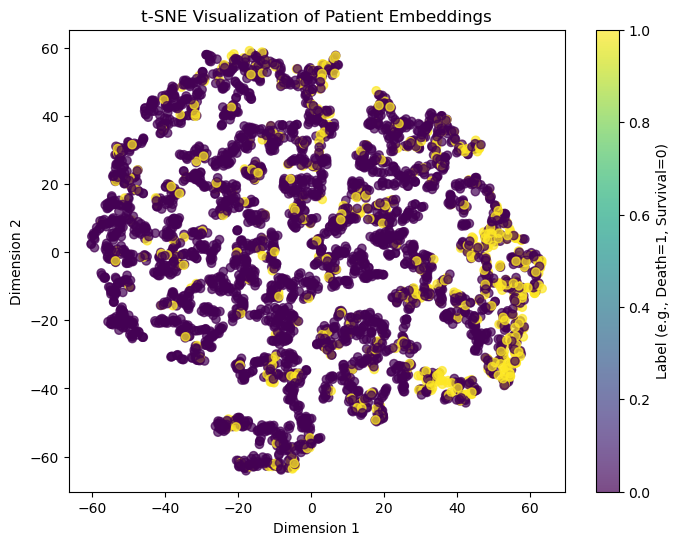

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Label (e.g., Death=1, Survival=0)')
plt.title("t-SNE Visualization of Patient Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Label (e.g., Death=1, Survival=0)')
plt.title("t-SNE Visualization of Patient Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [28]:
from sklearn.metrics import silhouette_score

# embeddings_2d: your 2D t-SNE or UMAP embeddings
# labels: corresponding class labels for each data point
sil_score = silhouette_score(embeddings, labels)
print("Silhouette Score:", sil_score)

Silhouette Score: 0.056406368
